In [1]:
import os, sys
sys.path.append('..')
sys.path.insert(0,'../submodule/m-phate')
sys.path.insert(0,'../submodule/OASIS')

In [2]:
import numpy as np
import pandas as pd
from random import shuffle
import scipy
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from importlib import import_module
import os, json, glob, struct, sys, time, gzip, copy, logging
import math, random, pickle
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
from sys import path

from joblib import Parallel, delayed

import matlab.engine
import engine

from pyexperimentparser.dataset.dataset import  Dataset
from pyexperimentparser.experiment.experiment import  Experiment
from pyexperimentparser.trial.trial import Trial
from pyexperimentparser.trial.bda import Bda
from pyexperimentparser.trial.tpa import Tpa
from pyexperimentparser.utils import preprocess
from pyexperimentparser.utils import utils

from importlib import import_module

from absl import app
from absl import logging
from absl import flags

In [3]:
import m_phate
import OASIS
import numpy as np
import scprep
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans

In [4]:
def parse(config):
  pars = config['parameters']
  return pars

In [5]:
with open('../config.json', 'r') as json_file:
    config = json.load(json_file)

pars = parse(config)
trial_ind_show = 0
data_dir = pars['data_dir']
# special trial (repetition) to show (Change it if you need)
rois_per_trial_num = pars['rois_per_trial_num']
# frame rate ratio between Two Photon imaging and Behavior
frame_rate_ratio      = pars['frame_rate_ratio']
# Common names to be converted to Ids
event_name_list      = pars['event_name_list']

procs = pars['processors']
verbosity = pars['verbosity']

ds = Dataset(verbosity, procs)

In [6]:
dates_to_process = pars['dates_to_process'] # e.g. 8_13_17, 8_6_17, 8_7_17 are "expert" days
cell_type = pars['cell_type']  # soma

In [7]:
dates_to_process

['8_13_17', '8_6_17', '8_7_17']

In [8]:
ds.load_from_pkl(data_dir, pars)
#ds.mat_to_pkl(data_dir, pars)

loading dataset from pickle with -1 threads, 11 verbosity


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s finished


In [9]:
## if importing .mat, need to start a virtual matlab instance
#import engine
#engine.init()
#ds.mat_to_pkl(data_dir, pars)

In [10]:
len(ds.experiment_list)

3

In [11]:
# compose list of trials.
Data_x = []
Data_y = []
for exp in tqdm(ds.experiment_list):
    for trial in exp.trial_list: 
        if len(trial.bda_list) < 1 or len(trial.tpa_list) < 1:
            continue
        # extract ROI df/F data
        rois_per_trial_num   = len(trial.tpa_list)
        dffData = trial.tpa_list[0].procROI
        framNum = dffData.shape[0]
        dffDataArray = np.tile(dffData, (rois_per_trial_num,1))
        roiNames = []

        for m in range(rois_per_trial_num):
            dffDataArray[m,:] = trial.tpa_list[m].procROI
            roiNames.append(trial.tpa_list[m].Name)

        # extract Event Time data
        eventsPerTrialNum   = len(trial.bda_list)
        timeData         = trial.bda_list[0].TimeInd
        eventDataArray   = np.zeros((framNum,eventsPerTrialNum))
        eventNames       = []

        for m in range(eventsPerTrialNum):
            timeInd     = np.array(trial.bda_list[m].tInd).flatten()
            timeInd     = np.round(timeInd/frame_rate_ratio) # transfers to time of the two photon

            timeInd     = np.concatenate(([1],[np.min(np.concatenate((timeInd, [framNum])))]))
            timeInd = np.sort(timeInd)
            eventDataArray[int(timeInd[0]):int(timeInd[1]),m] = 1
            eventNames.append((trial.bda_list[m].Name, trial.bda_list[m].SeqNum))

        if len(eventNames) > 1:
            Data_x.append(dffDataArray.T)
            if eventNames[1][0] == 'success':
                Data_y.append(1)
            else:
                Data_y.append(0)

Data_x_subset = []
Data_y_subset = []
for i, x in enumerate(Data_x):
    if x.shape[-1] == 379 and x.shape[0] == 360:
        Data_x_subset.append(x)
        Data_y_subset.append(Data_y[i])

In [12]:
# tensor of size trials x time x neurons
X = np.stack(Data_x_subset)

In [13]:
X.shape

(140, 360, 379)

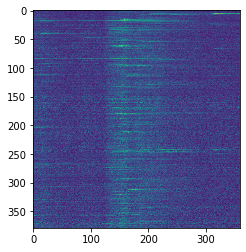

In [14]:
plt.imshow(Data_x_subset[5].T)

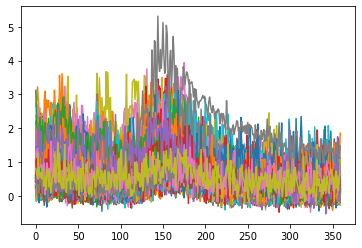

In [15]:
plt.plot(Data_x_subset[0])
plt.show()

In [25]:
X_tr.shape

(360, 140, 379)

In [26]:
X_tr = X.transpose(1,2,0)

In [30]:
X.shape

(140, 360, 379)

In [28]:
m_phate_op = m_phate.M_PHATE(normalize=False, n_components=2, n_jobs=-2)
m_phate_data = m_phate_op.fit_transform(X_tr)

Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 4.31 seconds.
  Calculated multislice kernel in 59.70 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 102.28 seconds.
      Calculating KMeans...
      Calculated KMeans in 79.25 seconds.
    Calculated landmark operator in 234.57 seconds.
  Calculated graph and diffusion operator in 247.77 seconds.
  Running PHATE on precomputed affinity matrix with 136440 cells.
  Calculating optimal t...
  Calculated optimal t in 14.24 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 5.75 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 350.12 seconds.
Calculated M-PHATE in 677.73 seconds.


In [31]:
n_trials = X.shape[0]
n_neurons = X.shape[2]
n_time = X.shape[1]

neuron_ids = np.tile(np.arange(n_neurons), n_time)
trial_ids = np.tile(np.arange(n_trials), n_time)
epoch = np.repeat(np.arange(n_time), n_trials)

In [34]:
n_trials, n_neurons, n_time

(140, 379, 360)

In [43]:
success_ids = np.tile(Data_y_subset, n_trials)

In [46]:
m_phate_data.shape

(136440, 2)

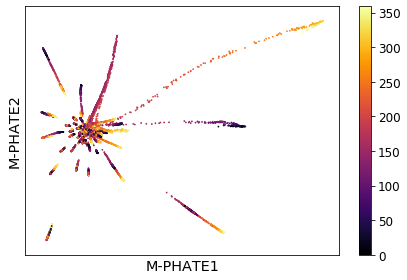

In [50]:
# plot
#n_time_steps, n_points, n_dim
time = np.repeat(np.arange(X.shape[1]), X.shape[2])
scprep.plot.scatter2d(m_phate_data, c=time, ticks=False, label_prefix="M-PHATE",filename=None)

In [23]:
m_phate_data.shape

(50400, 2)